In [1]:
import gym
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
from keras.models import Model
from keras.layers import Dense, Input


# action 1 to hit, 0 to stick
# ob = (player current sum, dealer's revealed card, have ace or not)
# 0.18


class DQNAgent_2:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        # soft update for target model
        self.tau = 0.01
        self.epsilon = 1
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.996
        self.gamma = 0.8
        self.batch_size = 100
        self.memory = deque(maxlen=2000)
        self.double_dqn = False
        self.input_, self.model = self.create_model()
        _, self.target_model = self.create_model()

    def create_model(self):
        input_ = Input(shape=(self.state_size,))
        hidden_layer_1 = Dense(units=128, activation='relu', input_shape=(self.state_size,))(input_)
        hidden_layer_2 = Dense(units=64, activation='relu', input_shape=(128,))(hidden_layer_1)
        hidden_layer_3 = Dense(units=32, activation='relu', input_shape=(64,))(hidden_layer_2)
        output = Dense(units=self.action_size, activation='linear', input_shape=(32,))(hidden_layer_3)
        model = Model(inputs=input_, outputs=output)
        model.compile(optimizer='adam', loss='mse')
        # return value of each action
        return input_, model

    def remember(self, cur_state, action, next_state, reward, done):
        self.memory.append([cur_state, action, next_state, reward, done])

    def act(self, cur_state):
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay
        if np.random.rand() < self.epsilon:
            return np.random.randint(0, 2)
        # its actually the predicted value of each action
        predicted_action = self.model.predict(cur_state)
        return np.argmax(predicted_action[0])

    def replay(self):
        mini_batch = random.sample(self.memory, self.batch_size)
        for cur_state, action_, next_state, reward_, done in mini_batch:
            target = self.model.predict(cur_state)
            if not done:
                if self.double_dqn:
                    predicted_action = np.argmax(self.model.predict(next_state)[0])
                    target_q = self.target_model.predict(next_state)[0][predicted_action]
                    target[0][action_] = reward_ + self.gamma * target_q
                else:
                    target_q = self.target_model.predict(next_state)[0]
                    target[0][action_] = reward_ + self.gamma * max(target_q)

            else:
                target[0][action_] = reward_

            self.model.fit(cur_state, target, verbose=0)

    def update_target_model(self):
        weights = self.model.get_weights()
        target_weights = self.target_model.get_weights()
        for i in range(len(target_weights)):
            target_weights[i] = weights[i] * self.tau + target_weights[i] * (1 - self.tau)
        self.target_model.set_weights(target_weights)

    def save(self, file):
        self.model.save_weights(file)

    def load(self, file):
        self.model.load_weights(file)
        self.target_model.load_weights(file)




Using TensorFlow backend.


stand1
hit0
double0
episode 0/15000, money_change:-1.0, e:0.996


stand59
hit77
double0
episode 100/15000, money_change:-42.0, e:0.5774699159923643


stand81
hit56
double0
episode 200/15000, money_change:-20.0, e:0.3334715038762283


stand89
hit47
double0
episode 300/15000, money_change:-12.0, e:0.19334313386471175


stand89
hit51
double0
episode 400/15000, money_change:-12.0, e:0.1103153971981959


stand98
hit28
double0
episode 500/15000, money_change:13.0, e:0.06657524516594461


stand95
hit31
double0
episode 600/15000, money_change:-6.0, e:0.04017810189218187


stand95
hit33
double0
episode 700/15000, money_change:-2.0, e:0.024053857513729304


stand98
hit37
double0
episode 800/15000, money_change:-17.0, e:0.014002172422365714


stand94
hit28
double0
episode 900/15000, money_change:-8.0, e:0.009999536012924389


stand96
hit38
double0
episode 1000/15000, money_change:3.0, e:0.009999536012924389


stand98
hit45
double0
episode 1100/15000, money_change:-4.0, e:0.009999536012924389


st

stand89
hit54
double0
episode 9600/15000, money_change:28.0, e:0.009999536012924389


stand92
hit57
double0
episode 9700/15000, money_change:0.0, e:0.009999536012924389


stand87
hit63
double0
episode 9800/15000, money_change:2.0, e:0.009999536012924389


stand89
hit45
double0
episode 9900/15000, money_change:-4.0, e:0.009999536012924389


stand87
hit59
double0
episode 10000/15000, money_change:-16.0, e:0.009999536012924389


stand92
hit64
double0
episode 10100/15000, money_change:0.0, e:0.009999536012924389


stand83
hit55
double0
episode 10200/15000, money_change:-3.0, e:0.009999536012924389


stand87
hit59
double0
episode 10300/15000, money_change:-18.0, e:0.009999536012924389


stand91
hit56
double0
episode 10400/15000, money_change:6.0, e:0.009999536012924389


stand91
hit47
double0
episode 10500/15000, money_change:-7.0, e:0.009999536012924389


stand91
hit39
double0
episode 10600/15000, money_change:-16.0, e:0.009999536012924389


stand88
hit48
double0
episode 10700/15000, money

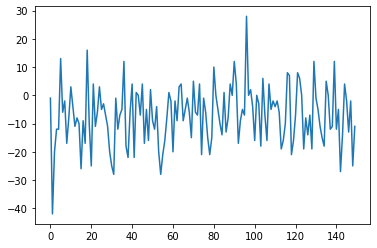

8930.0
0


In [10]:
env = gym.make('Blackjack-v0')
state_size_ = 3
action_size_ = 2
dqn_agent = DQNAgent_2(state_size_, action_size_)
#dqn_agent.load('poke_model_orig.h5')
n_episode = 15000
n_steps = 10
stand, hit, double = 0, 0, 0
bj_win = 0
money = 10000
cur_money = money
total_step = 0
mon = []
#start training
for episode_i in range(n_episode):
    cur_state_ = env.reset()
    for step_i in range(n_steps):
        total_step += 1
        cur_state_ = np.reshape(cur_state_, [1, dqn_agent.state_size])
        action = dqn_agent.act(cur_state_)
        if action == 0: 
            stand += 1
        elif action == 1:
            hit += 1
        else :
            double += 1
        observation, reward_, done_, _ = env.step(action)
        observation = np.reshape(observation, [1, dqn_agent.state_size])
        dqn_agent.remember(cur_state_, action, observation, reward_, done_)
        if total_step > dqn_agent.batch_size:
            dqn_agent.replay()
            dqn_agent.update_target_model()
        cur_state_ = observation
        if done_:
            if reward_ == 1.5:
                bj_win += 1
            money += reward_
            break

    if episode_i % 100 == 0:
        money_change = money - cur_money
        mon.append(money_change)
        dqn_agent.save('poke_model_orig.h5')
        print(f"stand{stand}")
        print(f"hit{hit}")
        print(f"double{double}")
        stand, hit, double = 0, 0, 0
        print("episode {}/{}, money_change:{}, e:{}".format(episode_i, n_episode, money_change, dqn_agent.epsilon))
        cur_money = money
        print()
        print()
plt.plot(mon)
plt.show()
print(money)
print(bj_win)


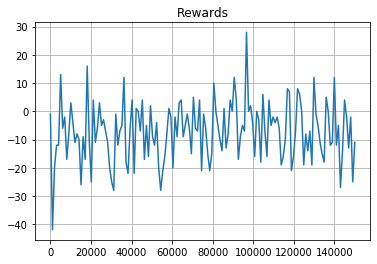

8930.0
0


In [12]:
ax = np.linspace(0,150000,num = 150)
plt.plot(ax,mon)
plt.title('Rewards',fontsize=12)
plt.grid()
plt.show()
print(money)
print(bj_win)

In [13]:
#from note import draw_graph
import numpy as np
import matplotlib.pyplot as plt

env = gym.make('Blackjack-v0')
state_size_, action_size_ = 3, 2    # 3,3
#dqn_agent = DQNAgent(state_size_, action_size_)
dqn_agent = DQNAgent_2(state_size_, action_size_)

#dqn_agent.load('poke_model_dd_u_2.h5') # Uniform DQNAgent
dqn_agent.load('poke_model_orig.h5') # Uniform DQNAgent


dqn_agent.epsilon  = 0
n_episode = 100000
n_steps = 1
stand, hit, double, surrender, bj_win = 0, 0, 0, 0, 0
money = 0
cur_money = money
game = []
moneys = []
for episode_i in range(n_episode):
    cur_state_ = env.reset()
    for step_i in range(n_steps):
        cur_state_ = np.reshape(cur_state_, [1, dqn_agent.state_size])
        action = dqn_agent.act(cur_state_)

        if action == 0:
             stand += 1
        elif action == 1:
             hit += 1
        elif action == 2:
             double += 1
        elif action == 3:
             surrender +=1
                
        observation, reward_, done_, _ = env.step(action)
        observation = np.reshape(observation, [1, dqn_agent.state_size])
        cur_state_ = observation
        if done_:
            if reward_ == 1.5:
                bj_win += 1
            money += reward_
            break
    if episode_i % 1000 == 0:
        money_change = money - cur_money
        game.append(money_change)
        cur_money = money
        moneys.append(money)



Stand Rate : 0.56812
Hit Rate : 0.43188
Double Rate : 0.0
Surrender Rate : 0.0
Total Times  : 100000
Money : -5143.0
BJ Win : 0
Expect Value : -0.05143
Expect Value : -0.05143


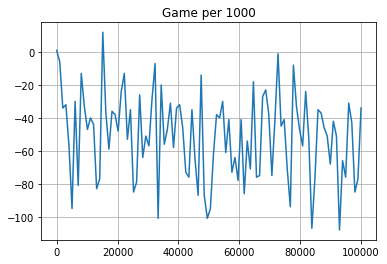

<function matplotlib.pyplot.show(*args, **kw)>

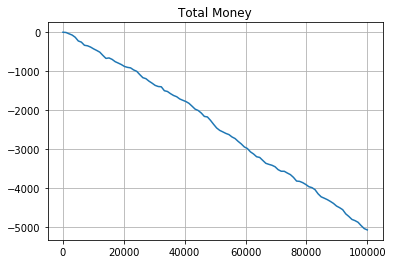

In [14]:
print(f"Stand Rate : {stand / (stand + hit + double+surrender)}")
print(f"Hit Rate : {hit / (stand + hit + double+surrender)}")
print(f"Double Rate : {double / (stand + hit + double+surrender)}")
print(f"Surrender Rate : {surrender / (stand + hit + double+surrender)}")


print(f"Total Times  : {stand + hit + double+surrender}")
print(f"Money : {money}")
print(f"BJ Win : {bj_win}")
print(f"Expect Value : {money/(stand + hit + double+surrender+bj_win)}")
print(f"Expect Value : {money/(100000)}")

ax = np.linspace(0,100000,num = 100)
plt.plot(ax,game)
plt.title('Game per 1000',fontsize=12)
plt.grid()
plt.show()


plt.plot(ax,moneys)
plt.title('Total Money',fontsize=12)
plt.grid()
plt.show